<a href="https://colab.research.google.com/github/LazaroR-u/EQNN/blob/main/tutorials/Quark_Gluon_p4m_EQNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
%%capture
pip install pennylane jax jaxlib

In [8]:
import pennylane as qml
from pennylane import numpy as np
import jax
from jax import numpy as jnp
import optax
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import h5py
import matplotlib.pyplot as plt


## load data

In [9]:
test = h5py.File("/content/QG_16x16x1_dataset_50k","r")

x_s = test.get('X')
y_s = test.get('y')

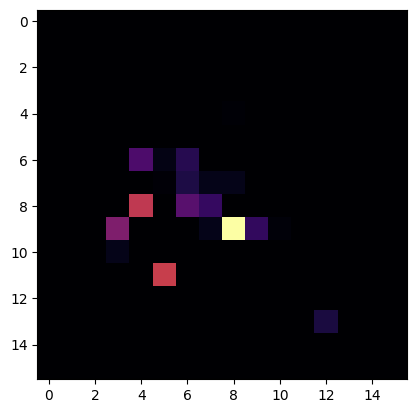

In [10]:
plt.imshow(x_s[0], cmap='inferno')
plt.show()

### Preprocessing data

In [12]:
def preprocess_jnp(
    classes: jnp.ndarray, trainloader: DataLoader, testloader: DataLoader
):
    r"""Load Data from PyTorch DataLoader into JAX NumPy Arrays

    Args:
        classes (jnp.ndarray) : List of integers representing data classes to be loaded.
            If None, return all classes.
        trainloader (torch.utils.data.DataLoader) : Trainset loader.
        testloader (torch.utils.data.DataLoader) : Testset loader.

    Returns:
        Tuple[jnp.ndarray, ...]: Tuple of training and test data/labels. The outputs are
        ordered as follows:

        * ``X_train``: Training samples of shape ``(num_train, img_size, img_size,
          num_channel)``.
        * ``Y_train``: Training labels of shape ``(num_train, )``.
        * ``X_test``: Test samples of shape ``(num_test, img_size, img_size,
          num_channel)``.
        * ``Y_train``: Test labels of shape ``(num_test, )``.
    """
    X_train = []
    Y_train = []

    X_test = []
    Y_test = []

    print(classes)
    # Load data as a np.ndarray
    for i, data in enumerate(trainloader, 0):
        image, label = data
        X_train.extend(list(jnp.transpose(image.detach().numpy(), (0, 2, 3, 1))))
        Y_train.extend(list(label.detach().numpy()))

    for i, data in enumerate(testloader, 0):
        image, label = data
        X_test.extend(list(jnp.transpose(image.detach().numpy(), (0, 2, 3, 1))))
        Y_test.extend(list(label.detach().numpy()))

    X_train = jnp.array(X_train)
    Y_train = jnp.array(Y_train)

    X_test = jnp.array(X_test)
    Y_test = jnp.array(Y_test)

    if classes is not None:
        train_mask = np.isin(Y_train, classes)
        X_train = X_train[train_mask]
        Y_train = Y_train[train_mask]

        Y_train = Y_train.at[jnp.argwhere(Y_train == classes[0])].set(0.0)
        Y_train = Y_train.at[jnp.argwhere(Y_train == classes[1])].set(1.0)

        test_mask = np.isin(Y_test, classes)
        X_test = X_test[test_mask]
        Y_test = Y_test[test_mask]
        Y_test = Y_test.at[jnp.argwhere(Y_test == classes[0])].set(0.0)
        Y_test = Y_test.at[jnp.argwhere(Y_test == classes[1])].set(1.0)

    return X_train, Y_train, X_test, Y_test


In [13]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import h5py
from sklearn.model_selection import train_test_split

class CustomDatasetFromHDF5(Dataset):
    def __init__(self, path, transform=None):
        file = h5py.File(path, "r")
        self.data = file["X"]
        self.labels = file["y"]
        self.transform = transform

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.labels)

# Definir transformaciones
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(90),
    transforms.ToTensor(),
])

# Crear dataset
data = CustomDatasetFromHDF5("/content/QG_16x16x1_dataset_50k", transform=transform)

train_size = int(data.labels.shape[0] * 0.8)
test_size = int(data.labels.shape[0] * 0.2)

train_ds = Subset(data, range(train_size))
test_ds = Subset(data, range(train_size, train_size + test_size))


# Crear dataloaders
trainloader = DataLoader(train_ds, batch_size=1000, shuffle=True)
testloader = DataLoader(test_ds, batch_size=1000, shuffle=True)

In [14]:
classes = [0,1]
X_train, Y_train, X_test, Y_test = preprocess_jnp(
            classes, trainloader, testloader
        )

[0, 1]


/usr/local/lib/python3.10/dist-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible

In [15]:
from collections import Counter

# Contadores para etiquetas
label_counts = Counter()

# Iterar sobre el dataloader
for _, labels in trainloader:
    label_counts.update(labels.numpy())

total_train = sum(label_counts.values())
count_0 = label_counts[0]
count_1 = label_counts[1]

print(f"Total de datos en entrenamiento: {total_train}")
print(f"Total de etiquetas 0: {count_0}")
print(f"Total de etiquetas 1: {count_1}")

Total de datos en entrenamiento: 40000
Total de etiquetas 0: 19975
Total de etiquetas 1: 20025


In [16]:
from collections import Counter

# Contadores para etiquetas
label_counts = Counter()

# Iterar sobre el dataloader
for _, labels in testloader:
    label_counts.update(labels.numpy())

total_test = sum(label_counts.values())
count_0 = label_counts[0]
count_1 = label_counts[1]

print(f"Total de datos en prueba: {total_test}")
print(f"Total de etiquetas 0: {count_0}")
print(f"Total de etiquetas 1: {count_1}")

Total de datos en prueba: 10000
Total de etiquetas 0: 5006
Total de etiquetas 1: 4994


## p4m EQNN

In [17]:
from typing import List
import jax.numpy as jnp

# Function to embed an image into a quantum state
def embed_image(img: jnp.ndarray, wires: List[int]) -> None:
    # n = 8
    n = len(wires) // 2

    # If the image is single-channel, reshape it to 2D
    if img.shape[2] == 1:
        img = img.reshape(img.shape[0], img.shape[1])

    # Initialize the feature vector with zeros
    features = jnp.zeros(2 ** (2*n)) # 2^(2*4) = 2^8 = 256 = 16x16

    # for each pixel in the image, we asign a value using the sine function with the
    # value of the pixel as an argument.

    # Then, Fill the feature vector with sine-transformed pixel values
    for i in range(2**n): # iterate in the width size (16 pixels)
        for j in range(2**n): # iterate in the height size (16 pixels)
            features = features.at[2**n * i + j].set(
                jnp.sin(jnp.pi / 2 * (2 * img[i, j] - 1))
            )

    # Normalize the feature vector
    features = features / jnp.sqrt(jnp.sum(features**2))

    # Use amplitude embedding to encode the feature vector into quantum state
    qml.AmplitudeEmbedding(features, wires=wires)

# Function to apply a U2 gate to a pair of qubits
def U2(phi, wires):
    qml.RX(phi[0], wires=wires[0])
    qml.RX(phi[1], wires=wires[1])
    qml.IsingZZ(phi[2], wires=wires)
    qml.RX(phi[3], wires=wires[0])
    qml.RX(phi[4], wires=wires[1])
    qml.IsingYY(phi[5], wires=wires)

# Function to apply a U4 gate to four qubits
def U4(phi, wires):
    qml.RX(phi[0], wires=wires[0])
    qml.RX(phi[1], wires=wires[1])
    qml.RX(phi[0], wires=wires[2])
    qml.RX(phi[1], wires=wires[3])

    # Define the Z matrix
    Z = jnp.array([[1, 0], [0, -1]])

    # Create a Kronecker product of Z matrices for four qubits
    Z4 = jnp.kron(Z, jnp.kron(Z, jnp.kron(Z, Z)))

    # Create a diagonal matrix with phase shifts
    Z4_diag = jnp.diag(jnp.exp(1j * phi[2] * Z4))

    # Apply a diagonal unitary matrix to the four qubits
    qml.DiagonalQubitUnitary(Z4_diag, wires=wires)

# Function to apply a pooling ansatz to a pair of qubits
def Pooling_ansatz(phi, wires):
    qml.RX(phi[0], wires=wires[0])
    qml.RX(phi[1], wires=wires[1])
    qml.RY(phi[2], wires=wires[1])
    qml.RZ(phi[3], wires=wires[1])
    qml.CRX(phi[4], wires=[wires[1], wires[0]])


In [18]:
# Function to define the full QCNN (Quantum Convolutional Neural Network) circuit
def qcnn_full(params, wires, trans_inv=True):
    if trans_inv:  # 14 params
        # Apply U2 gates in a translationally invariant manner
        for i in range(int(len(wires) / 2)):
            U2(params[:6], [wires[2 * i], wires[2 * i + 1]])
        U2(params[:6], [wires[1], wires[2]])
        U2(params[:6], [wires[5], wires[6]])
        U2(params[:6], [wires[0], wires[3]])
        U2(params[:6], [wires[4], wires[7]])

        # Insert a barrier to separate different parts of the circuit
        qml.Barrier()

        # Apply U4 gates
        U4(params[6:9], wires[0:4])
        U4(params[6:9], wires[4:8])
        U4(params[6:9], wires[2:6])
        U4(params[6:9], [wires[0], wires[1], wires[6], wires[7]])

        # Insert another barrier
        qml.Barrier()

        # Apply pooling ansatz
        for i in range(int(len(wires) / 2)):
            Pooling_ansatz(params[9:14], [wires[2 * i], wires[2 * i + 1]])

        # Final barrier
        qml.Barrier()

    else:  # 93 params
        # Apply U2 gates without translational invariance
        for i in range(int(len(wires) / 2)):
            U2(params[4 * i:i * 4 + 6], [wires[2 * i], wires[2 * i + 1]])
        U2(params[24:30], [wires[1], wires[2]])
        U2(params[30:36], [wires[5], wires[6]])
        U2(params[36:42], [wires[0], wires[3]])
        U2(params[42:48], [wires[4], wires[7]])

        # Insert a barrier
        qml.Barrier()

        # Apply U4 gates
        U4(params[48:51], wires[0:4])
        U4(params[51:54], wires[4:8])
        U4(params[54:57], wires[2:6])
        U4(params[57:60], [wires[0], wires[1], wires[6], wires[7]])

        # Insert another barrier
        qml.Barrier()

        # Apply pooling ansatz
        for i in range(int(len(wires) / 2)):
            Pooling_ansatz(params[60 + i * 5:60 + i * 5 + 5], [wires[2 * i], wires[2 * i + 1]])

        # Insert a barrier
        qml.Barrier()

        # Apply another U4 gate and pooling ansatz
        U4(params[80:83], [wires[1], wires[3], wires[5], wires[7]])

        # Insert a barrier
        qml.Barrier()

        # Apply final pooling ansatz
        Pooling_ansatz(params[83:88], [wires[1], wires[3]])
        Pooling_ansatz(params[88:93], [wires[5], wires[7]])



(<Figure size 3400x900 with 1 Axes>, <Axes: >)

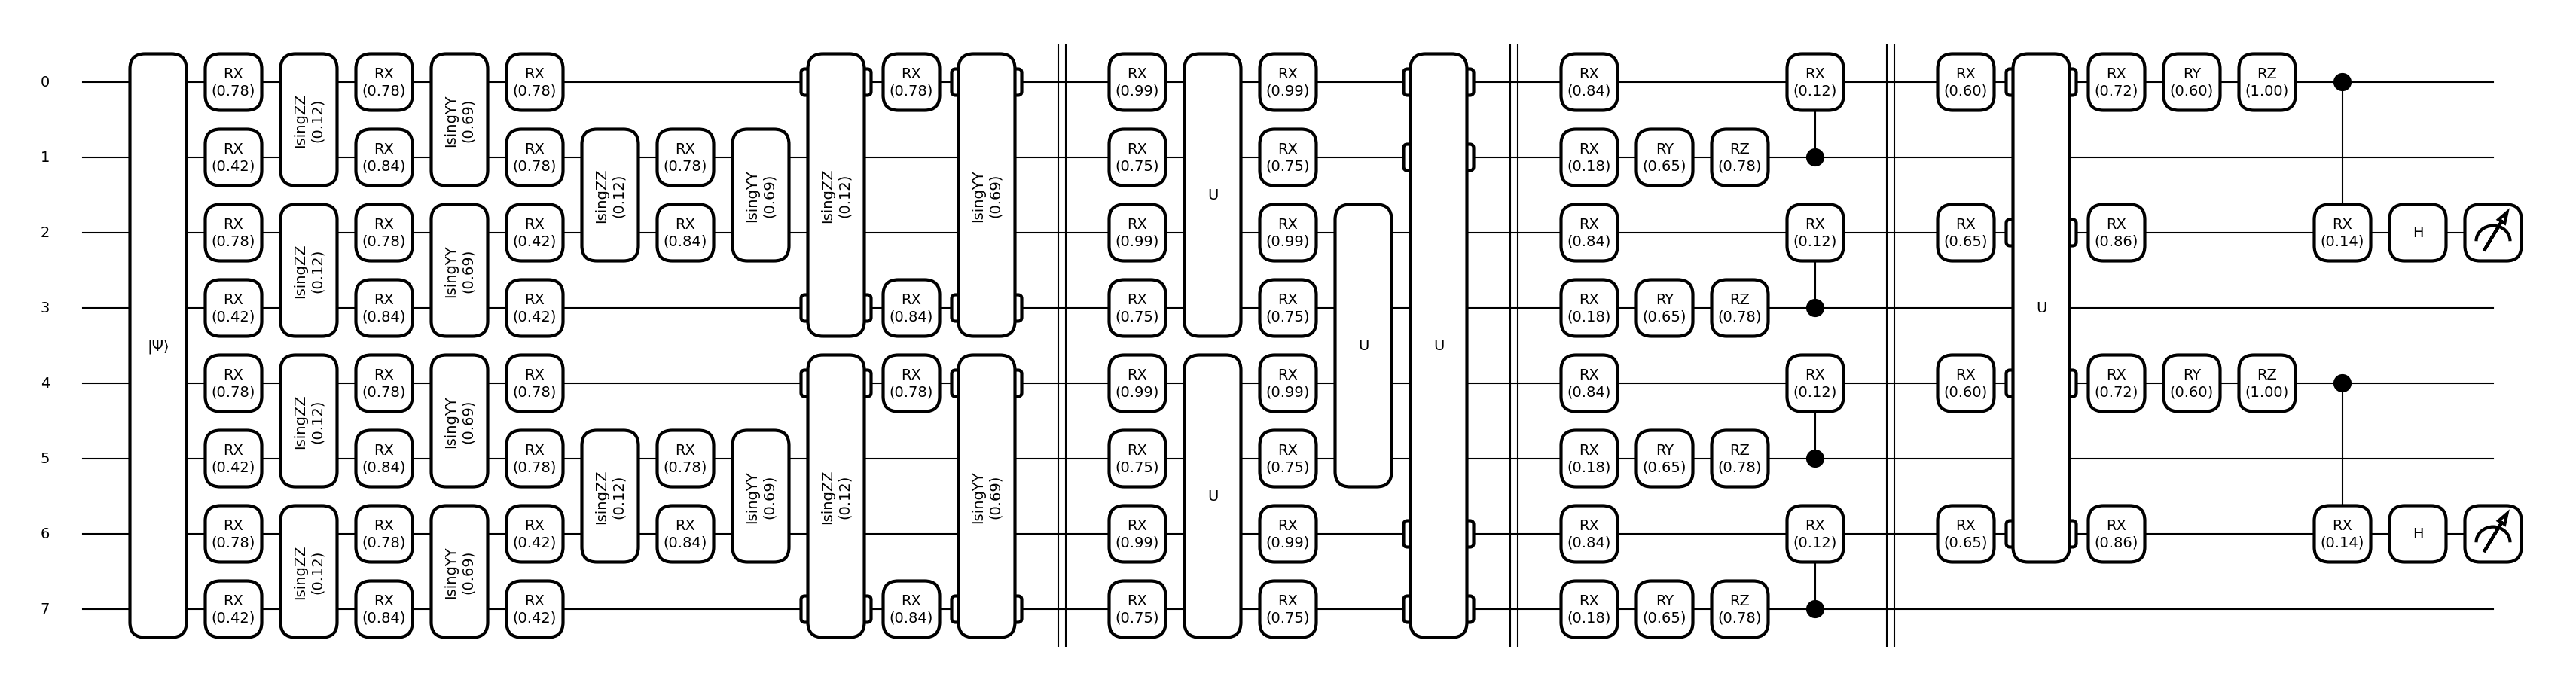

In [19]:
import pennylane as qml
import numpy as np
import jax
import jax.numpy as jnp
from typing import List

params = jnp.array(np.random.random(22))
matrix = jnp.array(X_train[1])
matrix_reflected = np.fliplr(matrix)
num_qubits = 8

dev = qml.device("default.qubit", wires=num_qubits)


@jax.jit
@qml.qnode(dev, interface="jax")
def EQNN_classifier_2m(X, params):
    embed_image(X, [0,1,2,3,4,5,6,7])
    qcnn_full(params, [0,1,2,3,4,5,6,7])
    U4(params[14:17], wires = [0,2,4,6])
    Pooling_ansatz(params[17:22], [2,0])
    Pooling_ansatz(params[17:22], [6,4])
    qml.Hadamard(2)
    qml.Hadamard(6)
    #return qml.probs(wires = [2]), qml.probs(wires = [6])
    return qml.expval(qml.PauliZ(2) @ qml.PauliZ(6))

def draw_circuit(matrix, params):
    matrix_np = np.array(matrix)
    params_np = np.array(params)
    @qml.qnode(dev)
    def temp_circuit():
        embed_image(matrix_np, [0,1,2,3,4,5,6,7])
        qcnn_full(params_np, [0,1,2,3,4,5,6,7])
        U4(params_np[14:17], wires = [0,2,4,6])
        Pooling_ansatz(params_np[17:22], [2,0])
        Pooling_ansatz(params_np[17:22], [6,4])
        qml.Hadamard(2)
        qml.Hadamard(6)
        #return qml.probs(wires = [2]), qml.probs(wires = [6])
        return qml.expval(qml.PauliZ(2) @ qml.PauliZ(6))

    return qml.draw_mpl(temp_circuit, decimals = 2)()

draw_circuit(matrix, params)


### Proof of Equivariance

In [20]:
matrix = jnp.array(X_train[0])

# Image Reflected over Y-axis
matrix_reflected_y = np.fliplr(matrix)

# Image Reflected over X-axis
matrix_reflected_x = np.flipud(matrix)

# Image rotated 90 degrees
matrix_rotated_90 = np.rot90(matrix)

# array to JAX
matrix_reflected_y_jax = jnp.array(matrix_reflected_y)
matrix_reflected_x_jax = jnp.array(matrix_reflected_x)
matrix_rotated_90_jax = jnp.array(matrix_rotated_90)


result1 = EQNN_classifier_2m(matrix, params)
result2 = EQNN_classifier_2m(matrix_reflected_y_jax, params)
result3 = EQNN_classifier_2m(matrix_reflected_x_jax, params)
result4 = EQNN_classifier_2m(matrix_rotated_90_jax, params)


print(f" Output with Probabilities for Original Image: {result1}")
print(f" Output with Probabilities for Image Reflected over Y-axis: {result2}")
print(f" Output with Probabilities for Image Reflected over X-axis: {result3}")
print(f" Output with Probabilities for Image Rotated 90 Degrees: {result4}")

plt.imshow(matrix, cmap='inferno')
plt.show()
plt.imshow(matrix_reflected_y, cmap='inferno')
plt.show()
plt.imshow(matrix_reflected_x, cmap='inferno')
plt.show()
plt.imshow(matrix_rotated_90, cmap='inferno')
plt.show()

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in astype is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


 Output with Probabilities for Original Image: 0.26995596289634705
 Output with Probabilities for Image Reflected over Y-axis: 0.2699558734893799
 Output with Probabilities for Image Reflected over X-axis: 0.2699558138847351
 Output with Probabilities for Image Rotated 90 Degrees: 0.26995599269866943


## training

In [22]:
jitcircuit = jax.jit(EQNN_classifier_2m)
vcircuit = jax.vmap(jitcircuit, (None, 0), 0)

# Define your model, optimizer, and other functions here

def map_loss(params, xbatch, ybatch):
    loss = 0
    for i, x in enumerate(xbatch):
        f = jitcircuit(x, params)
        loss += (ybatch[i] - f) ** 2
    return loss / len(xbatch)

# generate minibatches for X and Y
def iterate_minibatches(inputs, targets, batch_size):
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

# Define accuracy function
def accuracy(labels, predictions):
    # Convert predictions to binary 0 or 1
    binary_predictions = [1 if p >= 0.5 else 0 for p in predictions]
    correct_predictions = sum(l == p for l, p in zip(labels, binary_predictions))
    acc = correct_predictions / len(labels)
    return acc

In [23]:
learning_rate = 0.005
epochs = 10
batch_size = 100

In [24]:
optimizer = optax.adam(learning_rate)

weight_shapes = {"weights": (22,)}
key1 = jax.random.PRNGKey(0)
params = jax.random.uniform(key=key1, shape=weight_shapes["weights"])

opt_state = optimizer.init(params)

In [25]:
import time

n_train = 2000
n_test = 200

# Training and evaluation loop
start = time.time()

hist_loss = []
hist_val_loss = []
train_accuracy = []
test_accuracy = []

for it in range(epochs):
    start_b = time.time()
    for Xbatch, ybatch in iterate_minibatches(X_train[:n_train], Y_train[:n_train], batch_size=batch_size):
        grads = jax.grad(map_loss)(params, Xbatch, ybatch)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)

    loss = map_loss(params, X_train[:int(n_train/5)], Y_train[:int(n_train/5)])
    hist_loss.append(loss)
    val_loss = map_loss(params, X_test[:n_test], Y_test[:n_test])
    hist_val_loss.append(val_loss)

    # Calculate training and validation accuracy
    train_predictions = [jitcircuit(x, params) for x in X_train[:n_test]]
    train_acc = accuracy(Y_train[:n_test], train_predictions)
    train_accuracy.append(train_acc)

    test_predictions = [jitcircuit(x, params) for x in X_test[:n_test]]
    val_acc = accuracy(Y_test[:n_test], test_predictions)

    test_accuracy.append(val_acc)
    print("____")
    print(f"Epoch: {it} | Loss: {loss:.3f} | Val Loss: {val_loss:.3f} | Train Accuracy: {train_acc:.3f} | Val Accuracy: {val_acc:.3f}")
    print("____")

val_loss_final = map_loss(params, X_test[:n_test], Y_test[:n_test])
print("Final validation loss:", val_loss_final)

end = time.time()

print(f"Time for {epochs} epochs: {end - start}")

____
Epoch: 0 | Loss: 0.250 | Val Loss: 0.248 | Train Accuracy: 0.505 | Val Accuracy: 0.535
____
____
Epoch: 1 | Loss: 0.250 | Val Loss: 0.249 | Train Accuracy: 0.465 | Val Accuracy: 0.505
____
____
Epoch: 2 | Loss: 0.251 | Val Loss: 0.249 | Train Accuracy: 0.460 | Val Accuracy: 0.505
____
____
Epoch: 3 | Loss: 0.251 | Val Loss: 0.249 | Train Accuracy: 0.455 | Val Accuracy: 0.505
____
____
Epoch: 4 | Loss: 0.251 | Val Loss: 0.249 | Train Accuracy: 0.455 | Val Accuracy: 0.505
____
____
Epoch: 5 | Loss: 0.251 | Val Loss: 0.249 | Train Accuracy: 0.455 | Val Accuracy: 0.505
____
____
Epoch: 6 | Loss: 0.251 | Val Loss: 0.249 | Train Accuracy: 0.455 | Val Accuracy: 0.505
____
____
Epoch: 7 | Loss: 0.251 | Val Loss: 0.249 | Train Accuracy: 0.455 | Val Accuracy: 0.505
____
____
Epoch: 8 | Loss: 0.251 | Val Loss: 0.249 | Train Accuracy: 0.455 | Val Accuracy: 0.505
____
____
Epoch: 9 | Loss: 0.251 | Val Loss: 0.249 | Train Accuracy: 0.455 | Val Accuracy: 0.505
____
Final validation loss: 0.24898

## results

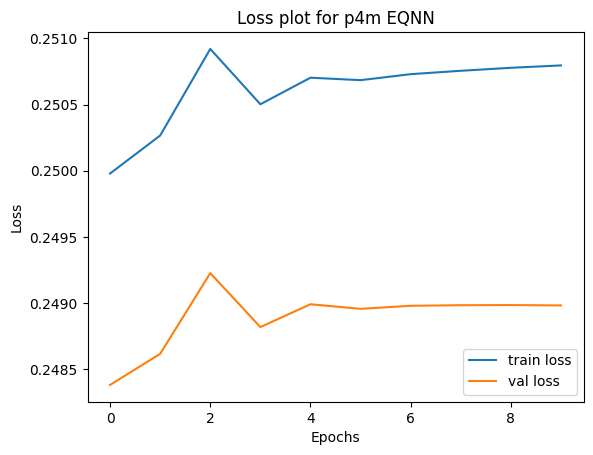

In [26]:
plt.plot(hist_loss, label = "train loss")
plt.plot(hist_val_loss, label = "val loss")
plt.title("Loss plot for p4m EQNN")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

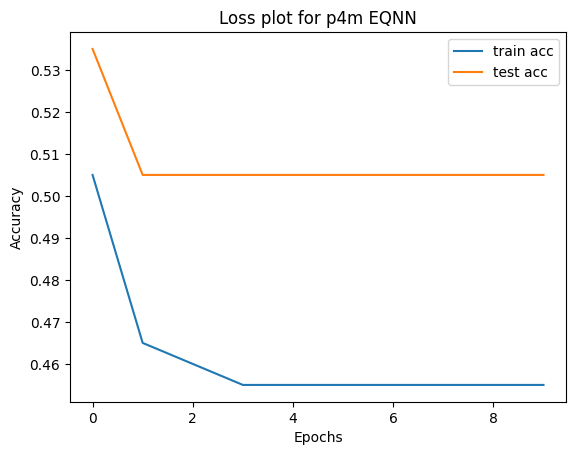

In [27]:
plt.plot(train_accuracy, label = "train acc")
plt.plot(test_accuracy, label = "test acc")
plt.title("Loss plot for p4m EQNN")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()